In [185]:
import sys
import subprocess
import pkg_resources

required = {'numpy', 'pandas', 'pathlib', 'nltk'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [186]:
import numpy as np
import pandas as pd
import json

# Import data

In [187]:
DATASET_PATH = './artifacts/merged.json'

In [188]:
dataset = None
with open(DATASET_PATH) as json_file:
    dataset_raw = json.load(json_file)
    columns = dataset_raw['catalog'][0].keys()
    dataset = pd.DataFrame(columns=columns, data=dataset_raw['catalog'])
    
# transormations
for index, row in dataset.iterrows():
    if row['category'] == '#comp-comments':
        row['article_id'] = row['article_id'][:-len('/#comp-comments-button')]
        url = row['article_id']
        row['category'] = url[url.rfind('/')+1:url.rfind('-')]
        
dataset

,article_id,category,title,tags,text
0,http://www.bbc.co.uk/news/world-europe-55497084,world-europe,Brexit: Gibraltar gets UK-Spain deal to keep o...,"Gibraltar,Spain,Effects of Brexit on Gibraltar...",Spain has reached a deal with the UK to mainta...
1,http://www.bbc.co.uk/news/uk-northern-ireland-...,uk-northern-ireland,Covid-19: Homeschooling returns for first week...,"NI education,Coronavirus lockdown measures,Cor...",Most pupils in Northern Ireland will not be re...
2,http://www.bbc.co.uk/news/business-55494101,business,Adieu to the single market created by the UK,"Companies,EU-UK post-Brexit trade talks,Boris ...",Nearly half a century of the UK's membership o...
3,http://www.bbc.co.uk/news/uk-england-merseysid...,uk-england-merseyside,Joe Anderson: Liverpool mayor in police probe ...,"Liverpool City Council,Liverpool",Liverpool Mayor Joe Anderson says he will not ...
4,http://www.bbc.co.uk/news/uk-55502595,uk,"Covid-19: UK reports a record 55,892 daily cases","Healthcare,Coronavirus pandemic","The UK has reported another 55,892 daily cases..."
...,...,...,...,...,...
23602,http://www.bbc.co.uk/news/world-australia-5947...,world-australia,Australian parliament: One in three workers se...,"Sexual harassment,Australia",A third of employees in Australia's federal pa...
23603,http://www.bbc.co.uk/news/explainers-52544307,explainers,What Covid tests do I still need to travel abr...,"Tourism,Spain,France,Coronavirus lockdown meas...","From next month, fully vaccinated people trave..."
23604,http://www.bbc.co.uk/news/world-middle-east-59...,world-middle-east,Yemen: The children haunted by 'ghosts' of war,NaN,
23605,http://www.bbc.co.uk/news/business-59466803,business,Facial recognition firm faces possible £17m pr...,"Facial recognition,Information Commissioner's ...",An Australian firm which claims to have a data...


In [189]:
dataset['category'].value_counts()[:20]

uk                               3507
business                         2323
uk-wales                         1936
health                           1457
world-us-canada                  1414
uk-politics                      1389
uk-northern-ireland              1231
world-europe                     1015
uk-scotland                       863
entertainment-arts                833
world-asia                        672
science-environment               565
uk-england-london                 559
explainers                        435
technology                        409
education                         337
uk-wales-politics                 331
world-middle-east                 315
uk-scotland-scotland-politics     266
world                             247
Name: category, dtype: int64

In [190]:
categories_to_keep = ['business', 'health', 'uk-politics', 'entertainment-arts']
max_category_size = 1000

dataset = dataset[dataset['category'].isin(categories_to_keep)]
category_datasets = []
for category in categories_to_keep:
    category_datasets.append(dataset[dataset['category'] == category][:max_category_size])
    
result = category_datasets[0]
for ds in category_datasets[1:]:
    result = result.append(ds)
    
dataset = result
dataset

,article_id,category,title,tags,text
2,http://www.bbc.co.uk/news/business-55494101,business,Adieu to the single market created by the UK,"Companies,EU-UK post-Brexit trade talks,Boris ...",Nearly half a century of the UK's membership o...
9,http://www.bbc.co.uk/news/business-55501049,business,'Worst year for High Street job losses in 25 y...,"Retailing,UK economy,UK High Streets",Last year was the worst for the High Street in...
35,http://www.bbc.co.uk/news/business-55502252,business,Activists cheer as 'sexist' tampon tax is scra...,"Companies,Budget 2020,Women's health,Money,Per...",The 5% rate of VAT on sanitary products - refe...
76,http://www.bbc.co.uk/news/business-55515529,business,"Bitcoin tops $34,000 as record rally continues","Bitcoin,Cryptocurrency","Bitcoin's value surged above $34,000 (£24,850)..."
173,http://www.bbc.co.uk/news/business-55522104,business,'Furlough mums and dads while schools are off'...,"Trades Union Congress,Job Retention Scheme,Cor...",Working parents trying to balance work and chi...
...,...,...,...,...,...
23480,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Radio 4's Today programme temporarily drops of...,Radio,Radio 4's Today programme temporarily dropped ...
23503,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Storm Arwen: I'm a Celebrity to return on Tues...,"ITV,Television,I'm a Celebrity...Get Me Out of...",Live episodes of I'm a Celebrity... Get Me Out...
23507,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Steps axe their remaining tour dates due to fu...,Live music,Pop group Steps have announced they have are p...
23536,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Adele announces Las Vegas residency,"Las Vegas,Music,Adele",Adele has announced a Las Vegas residency with...


In [191]:
print(dataset.isna().sum())
dataset = dataset.dropna()

article_id      0
category        0
title           0
tags          193
text            0
dtype: int64


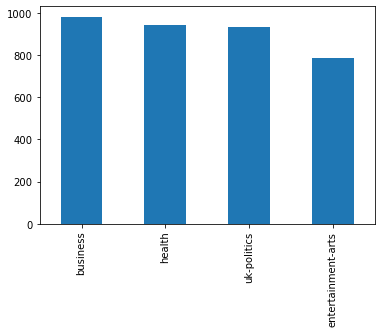

In [192]:
s = dataset['category'].value_counts()
s.plot(kind='bar')

# Text Pre-Processing - Stop-word removal, Stemming, Vectorization

In [193]:
import re 
from os import listdir
from os.path import isfile, join
import json
import pathlib
import re 
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/pazamelin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pazamelin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [194]:
import sklearn
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

stop_words = stopwords.words('english')
VECTORIZER = None

def clean(text):
    cleaned = re.sub(re.compile('<.*?>'), '', text)
    cleaned = re.sub('[^A-Za-z0-9]+', ' ', cleaned)
    cleaned = cleaned.lower()
    return cleaned
    
    
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens


def remove_stop_words(tokens):
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens


def apply_stemming(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens
    

def vectorize(tokens, vectorizer):
    vectorized_tokens = vectorizer.fit(tokens)
    return vectorized_tokens


def preprocess_text(text):
    cleaned_text = clean(text)
    tokens = tokenize(cleaned_text)
    tokens = remove_stop_words(tokens)
    tokens = remove_stop_words(tokens)
    tokens = apply_stemming(tokens)
    return tokens


def vectorize(vectorizer, preprocessed_text):
    vectorized = vectorizer.transform([preprocessed_text]).toarray()
    return vectorized



In [195]:
# dataset = dataset[:100]

# preprocess corpus
for index, row in dataset.iterrows():
    row['text'] = preprocess_text(row['text'])
    row['text'] = ' '.join(row['text'])
    
dataset

,article_id,category,title,tags,text
2,http://www.bbc.co.uk/news/business-55494101,business,Adieu to the single market created by the UK,"Companies,EU-UK post-Brexit trade talks,Boris ...",nearli half centuri uk membership european uni...
9,http://www.bbc.co.uk/news/business-55501049,business,'Worst year for High Street job losses in 25 y...,"Retailing,UK economy,UK High Streets",last year worst high street 25 year coronaviru...
35,http://www.bbc.co.uk/news/business-55502252,business,Activists cheer as 'sexist' tampon tax is scra...,"Companies,Budget 2020,Women's health,Money,Per...",5 rate vat sanitari product refer tampon tax a...
76,http://www.bbc.co.uk/news/business-55515529,business,"Bitcoin tops $34,000 as record rally continues","Bitcoin,Cryptocurrency",bitcoin valu surg 34 000 24 850 first time sun...
173,http://www.bbc.co.uk/news/business-55522104,business,'Furlough mums and dads while schools are off'...,"Trades Union Congress,Job Retention Scheme,Cor...",work parent tri balanc work childcar put furlo...
...,...,...,...,...,...
23480,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Radio 4's Today programme temporarily drops of...,Radio,radio 4 today programm temporarili drop air mo...
23503,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Storm Arwen: I'm a Celebrity to return on Tues...,"ITV,Television,I'm a Celebrity...Get Me Out of...",live episod celebr get return tuesday itv conf...
23507,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Steps axe their remaining tour dates due to fu...,Live music,pop group step announc postpon remaind uk tour...
23536,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Adele announces Las Vegas residency,"Las Vegas,Music,Adele",adel announc la vega resid weekend perform due...


In [196]:
# # create vectorizer

vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(all_texts)
print(len(vectorizer.vocabulary_.keys()))
# vectorizer.vocabulary_

3764


In [197]:
# vectorize preprocessed text
for index, row in dataset.iterrows():
    row['text'] = vectorize(vectorizer, row['text'])[0]

dataset

,article_id,category,title,tags,text
2,http://www.bbc.co.uk/news/business-55494101,business,Adieu to the single market created by the UK,"Companies,EU-UK post-Brexit trade talks,Boris ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,http://www.bbc.co.uk/news/business-55501049,business,'Worst year for High Street job losses in 25 y...,"Retailing,UK economy,UK High Streets","[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
35,http://www.bbc.co.uk/news/business-55502252,business,Activists cheer as 'sexist' tampon tax is scra...,"Companies,Budget 2020,Women's health,Money,Per...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
76,http://www.bbc.co.uk/news/business-55515529,business,"Bitcoin tops $34,000 as record rally continues","Bitcoin,Cryptocurrency","[1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
173,http://www.bbc.co.uk/news/business-55522104,business,'Furlough mums and dads while schools are off'...,"Trades Union Congress,Job Retention Scheme,Cor...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
23480,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Radio 4's Today programme temporarily drops of...,Radio,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
23503,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Storm Arwen: I'm a Celebrity to return on Tues...,"ITV,Television,I'm a Celebrity...Get Me Out of...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
23507,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Steps axe their remaining tour dates due to fu...,Live music,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
23536,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Adele announces Las Vegas residency,"Las Vegas,Music,Adele","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [198]:
print(dataset.iloc[0]['text'])
print(len(dataset.iloc[0]['text']))

[0 0 0 ... 0 0 2]
3764


# Classification